#### Описание данных

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
<br>
<br>
без подписки <br>
абонентская плата отсутствует;<br>
стоимость одной минуты поездки — 8 рублей;<br>
стоимость старта (начала поездки) — 50 рублей;<br>
<br>
<br>
с подпиской Ultra <br> 
абонентская плата — 199 рублей в месяц;<br>
стоимость одной минуты поездки — 6 рублей;<br>
стоимость старта — бесплатно.


user_go.csv содержит следующую информацию:
- `user_id`	уникальный идентификатор пользователя
- `name`	имя пользователя
- `age`	возраст
- `city`	город
- `subscription_type`	тип подписки (free, ultra)


rides_go.csv содержит следующую информацию:
- `user_id`	уникальный идентификатор пользователя
- `distance`	расстояние, которое пользователь проехал в текущей сессии (в метрах)
-`duration`	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date`	дата совершения поездки

subscriptions_go.csv содержит следующую информацию:
- `subscription_type`	тип подписки
- `minute_price`	стоимость одной минуты поездки по данной подписке
- `start_ride_price`	стоимость начала поездки
- `subscription_fee`	стоимость ежемесячного платежа

**Цель исследования:** Проанализировать данные и проверить гипотезы, которые могут помочь бизнесу вырасти

In [1]:
import numpy as np
# Импортируем необходимые библиотеки
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
import warnings

# warnings.simplefilter("ignore")

#### Шаг 1. Загрузка данных

In [2]:
try:
    users_df = pd.read_csv('/Users/moncervers/PycharmProjects/portfolio/scooters_analysis/data/users_go.csv')
    rides_df = pd.read_csv('/Users/moncervers/PycharmProjects/portfolio/scooters_analysis/data/rides_go.csv')
    subscriptions_df = pd.read_csv('/Users/moncervers/PycharmProjects/portfolio/scooters_analysis/data/subscriptions_go.csv')
except:
    users_df = pd.read_csv('/datasets/users_go.csv')
    rides_df = pd.read_csv('/datasets/rides_go.csv')
    subscriptions_df = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
# Просматриваем информацию о пользователях
users_df.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
# Просматриваем информацию о поездках
rides_df.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
# Просматриваем информацию о тарифах
subscriptions_df

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


##### Вывод:

Всего у нас есть 3 датафрейма, в которых отсутствуют пропуски, а все столбцы, кроме столбца с датой приведены к корректному типу данных

#### Шаг 2. Предобработка данных

Приведем столбец `date` в таблице `rides_df` к нужному типу данных создадим отдельный столбец с месяцем

In [8]:
rides_df['date'] = pd.to_datetime(rides_df['date'], format='%Y-%m-%d')
rides_df['month'] = rides_df['date'].dt.month
rides_df['weekday'] = rides_df['date'].dt.weekday  # создаем столбец с выделением дня недели из даты
rides_df.head()

,user_id,distance,duration,date,month,weekday
0,1,4409.919140,25.599769,2021-01-01,1,4
1,1,2617.592153,15.816871,2021-01-18,1,0
2,1,754.159807,6.232113,2021-04-20,4,1
3,1,2694.783254,18.511000,2021-08-11,8,2
4,1,4028.687306,26.265803,2021-08-28,8,5


In [9]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int32         
 5   weekday   18068 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(2), int64(1)
memory usage: 705.9 KB


Проверим наличие пропусков и дубликатов в датафреймах

In [10]:
print('Users: \n', users_df.isna().sum())
print()
print('Rides: \n', rides_df.isna().sum())
print()
print('Subscriptions: \n', subscriptions_df.isna().sum())

Users: 
 user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Rides: 
 user_id     0
distance    0
duration    0
date        0
month       0
weekday     0
dtype: int64

Subscriptions: 
 subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


Проверим датафреймы на наличие явных дубликатов

In [11]:
print('users: \n', users_df.duplicated().sum())
print()
print('rides: \n', rides_df.duplicated().sum())
print()
print('subscriptions: \n', subscriptions_df.duplicated().sum())

users: 
 31

rides: 
 0

subscriptions: 
 0


In [12]:
# Смотрим, какие дубликаты у нас присутствуют
users_df[users_df.duplicated()].head()

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free


In [13]:
# Перед удалением дубликатов, проверим, нет ли неочевидной разницы
users_df[users_df['user_id'] == 293]

,user_id,name,age,city,subscription_type
292,293,Агата,26,Краснодар,ultra
1534,293,Агата,26,Краснодар,ultra


In [14]:
# Удаляем дубликаты
users_df = users_df.drop_duplicates().reset_index(drop=True)

print(users_df.duplicated().sum())
users_df.head()

0


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


##### Вывод:
- В датафрейме `rides_df` мы привели столбец `date` к корректному типу данных.
- В датафрейме `users_df` мы удалили 31 неявный дубликат

In [15]:
temp = rides_df.copy() # Создаем копию, что бы не изменять текущий датасет
display(temp['distance'].head(3))

# Округление расстояния
temp['distance'] = temp['distance'].round(2)
temp['distance'].head(3)

0    4409.919140
1    2617.592153
2     754.159807
Name: distance, dtype: float64

0    4409.92
1    2617.59
2     754.16
Name: distance, dtype: float64

#### Шаг 3. Исследовательский анализ данных

Проведем исследовательский анализ данных. Изучим следующие параметры:
1. Насколько часто встречаются города 
2. Соотношение пользователя с подпиской и без нее
3. Возраст пользователей
4. Расстояние, которое пользователь преодолел за одну поездку
5. Продолжительность поездок

##### Частота городов

Посмотрим, сколько пользователей в каждом из городов

In [16]:
users_df

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1529,1530,Ростислав,29,Сочи,free
1530,1531,Никита,25,Пятигорск,free
1531,1532,Алексей,26,Тюмень,free
1532,1533,Степан,22,Краснодар,free


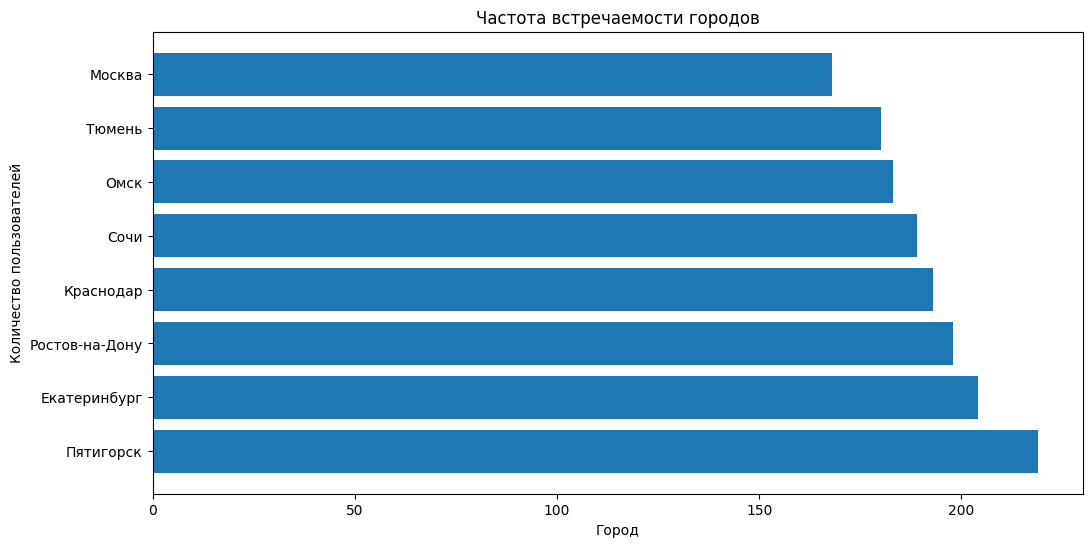

In [17]:
# Создадим сводную таблицу для пользователей
pivot_table_df = (users_df.pivot_table(index='city', values='age',
                                      aggfunc=('median', 'mean', 'count', 'min', 'max'))
                                      .sort_values('count', ascending=False))

plt.figure(figsize=(12, 6))
plt.barh(pivot_table_df.index, pivot_table_df['count'])
plt.xlabel('Город')
plt.ylabel('Количество пользователей')
plt.title('Частота встречаемости городов')

plt.show()

In [18]:
pivot_table_df['count']

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

Мы можем наблюдать, что меньше всего пользователей сервиса приходится в Москве, в то время как больше всего в Пятигорске. Однако количество пользователей распределено примерно одинаково по всем городам. В Пятигорске примерно на 60 пользователей больше, чем в Москве

##### Соотношение пользователей

Посмотрим на то, какое у нас соотношение пользоватей с подпиской и без нее

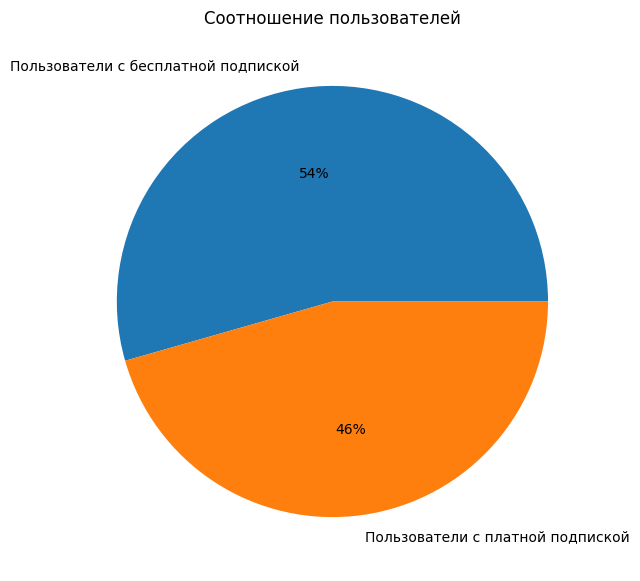

Всего у нас835пользователей с бесплатной подпиской и699пользователей с платной подпиской 
 
На одного пользователя с платной подпиской приходится1.19пользователей с бесплатной подпиской


In [19]:
# Нарисуем круговую диаграмму соотношения пользователей
plt.figure(figsize=(7, 7))
plt.pie(
    (users_df.loc[users_df['subscription_type'] == 'free', 'subscription_type'].count(),
     users_df.loc[users_df['subscription_type'] == 'ultra', 'subscription_type'].count()),
    labels=('Пользователи с бесплатной подпиской', 'Пользователи с платной подпиской'),
    autopct='%1.0f%%'
)

plt.title('Соотношение пользователей')
plt.show()

print(f"Всего у нас\
{users_df.loc[users_df['subscription_type'] == 'free', 'subscription_type'].count()}\
пользователей с бесплатной подпиской и\
{users_df.loc[users_df['subscription_type'] == 'ultra', 'subscription_type'].count()}\
пользователей с платной подпиской \n ")

print(f"На одного пользователя с платной подпиской приходится\
{users_df.loc[users_df['subscription_type'] == 'free', 'subscription_type'].count() / users_df.loc[users_df['subscription_type'] == 'ultra', 'subscription_type'].count():.2f}\
пользователей с бесплатной подпиской")

##### Анализ возраста пользователей

Посмотрим на то, как распределен возраст пользователей. Ранее мы созадавали сводную таблицу с возрастом, выведем ее

In [20]:
# Проанализируем возраст пользователей сервиса
pivot_table_df

,count,max,mean,median,min
city,,,,,
Пятигорск,219,36,24.716895,25.0,12
Екатеринбург,204,35,24.955882,25.0,13
Ростов-на-Дону,198,37,24.545455,25.0,12
Краснодар,193,38,25.290155,25.0,13
Сочи,189,36,24.507937,25.0,12
Омск,183,38,25.382514,26.0,13
Тюмень,180,38,24.638889,25.0,13
Москва,168,43,25.267857,25.0,13


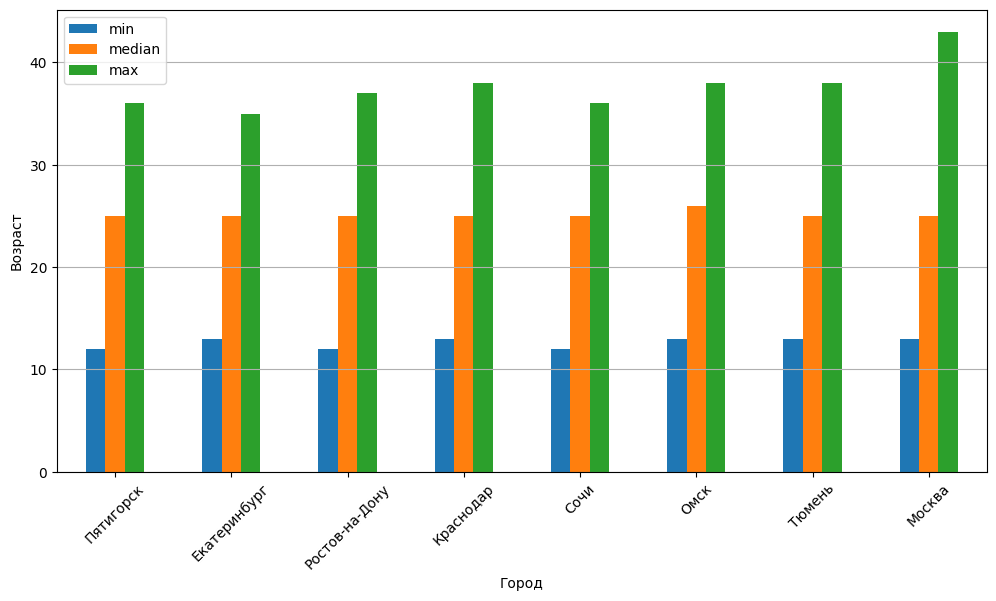

In [21]:

pivot_table_df[['min', 'median', 'max']].plot(kind='bar', stacked=False, figsize=(12, 6))
plt.xticks(rotation=45)
plt.xlabel('Город')
plt.ylabel('Возраст')

plt.grid(axis='y')
plt.show()

Мы можем наблюдать, что минимальный, медианный, и максимальный возраст пользователей не сильно отличается в зависимости от города. Однако мы можем отметить Москву, как город, в котором максимальный возраст значительно отличается в сравнении с остальными городами. В Москве максимальный возраст составляет аж 43 года.

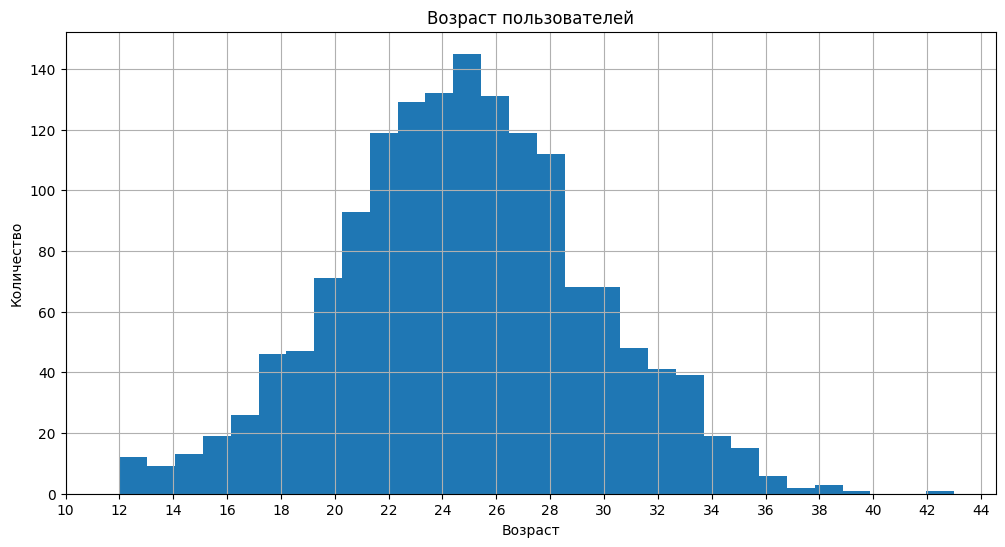

In [22]:
# Потроим гистограмму возраста пользователей
plt.figure(figsize=(12, 6))

plt.hist(users_df['age'], bins=30)
plt.xlabel('Возраст')
plt.xticks(range(10,45,2))
plt.ylabel('Количество')
plt.title('Возраст пользователей')

plt.grid()
plt.show()

Мы можем видеть, что расределение возраста похоже на нормальное, с медианным значением, равным примерно  25.

##### Расстояние, преодоленное за одну поездку

Посмотрим, как распределено расстояние, сорвешненое за одну поездку, а так же как это расстояние меняется в зависиммости от месяца и дня недели

In [23]:
rides_df.head()

,user_id,distance,duration,date,month,weekday
0,1,4409.919140,25.599769,2021-01-01,1,4
1,1,2617.592153,15.816871,2021-01-18,1,0
2,1,754.159807,6.232113,2021-04-20,4,1
3,1,2694.783254,18.511000,2021-08-11,8,2
4,1,4028.687306,26.265803,2021-08-28,8,5


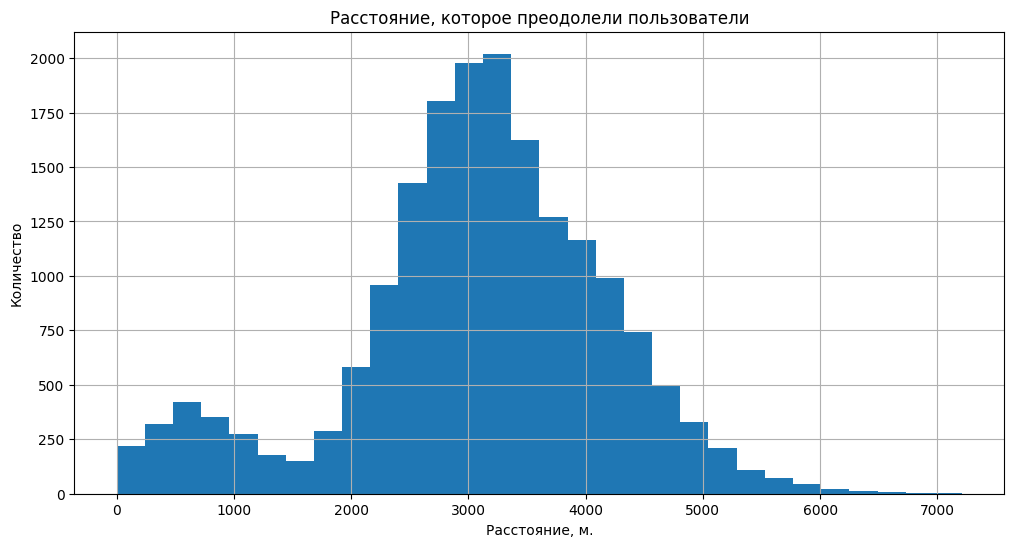

In [24]:
# Потроим гистограмму расстояния, которое преодолели пользователи
plt.figure(figsize=(12, 6))

plt.hist(rides_df['distance'], bins=30)
plt.xlabel('Расстояние, м.')
# plt.xticks(range(10,45,2))
plt.ylabel('Количество')
plt.title('Расстояние, которое преодолели пользователи')

plt.grid()
plt.show()

Мы видим, что есть определенный "пласт" пользователей, которые арендуют самокат на небольшие расстояния. Скорее всего, такие пользователи арендуют его для того, чтобы добраться до ближайшего метро. Далее мы видим "всплеск" пользователей, которые арендуют самокаты на более продолжительное расстояние. Скорее всего, такие пользователи арендуют их для прогулки, либо для того, чтобы добраться куда-то, не дожидаясь общественного транспорта

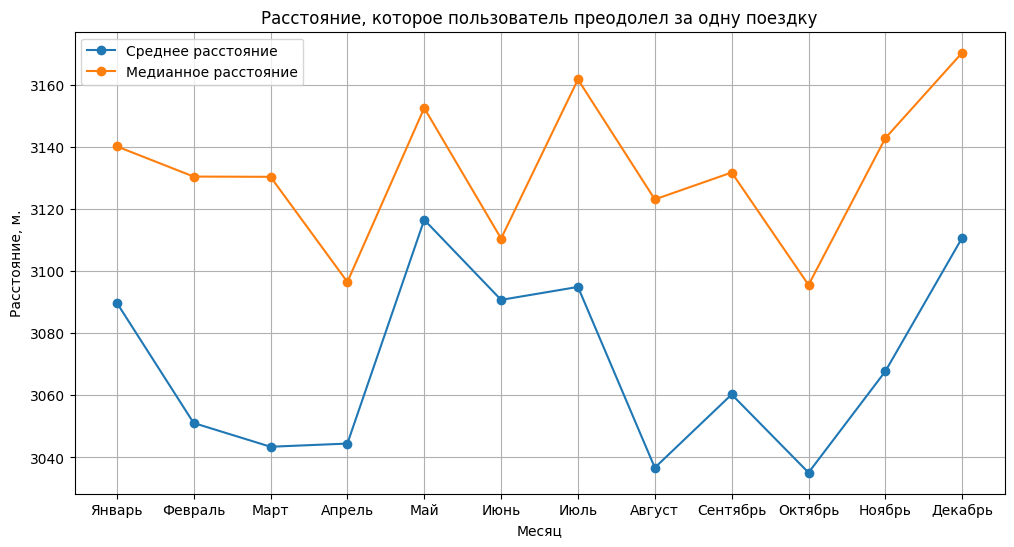

In [25]:
# Посмотрим на то, как месяц влияет на дистанцию поездки
pivot_table_df = rides_df.pivot_table(index='month', values='distance',
                                      aggfunc=('mean', 'median', 'min', 'max', 'count')).sort_values('month')

pivot_table_df = pivot_table_df.rename(index={
    1: 'Январь',
    2: 'Февраль',
    3: 'Март',
    4: 'Апрель',
    5: 'Май',
    6: 'Июнь',
    7: 'Июль',
    8: 'Август',
    9: 'Сентябрь',
    10: 'Октябрь',
    11: 'Ноябрь',
    12: 'Декабрь'
}).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(pivot_table_df['month'], pivot_table_df[['mean', 'median']], marker='o')
plt.xlabel('Месяц')
plt.ylabel('Расстояние, м.')
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.legend(('Среднее расстояние', 'Медианное расстояние'))

plt.grid(True)
plt.show()

Мы видим, что в расстояние, которое преодолевает на самокате больше всего в теплые месяцы, однако стоит отметить "выброс" в декабре и январе. 

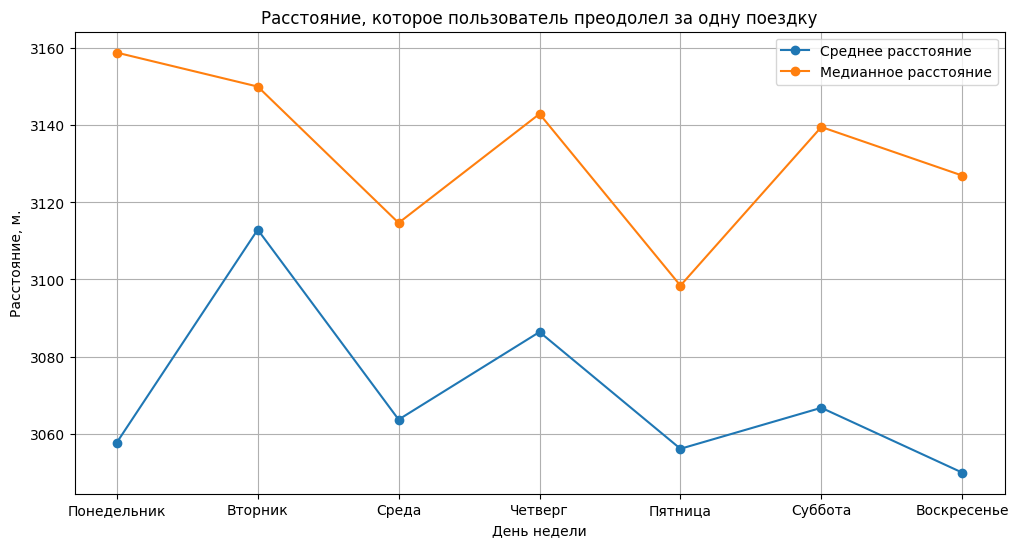

In [26]:
# Посмотрим на то, как день недели влияет на дистанцию поездки
pivot_table_df = rides_df.pivot_table(index='weekday', values='distance',
                                      aggfunc=('mean', 'median', 'min', 'max')).sort_values('weekday')

pivot_table_df = pivot_table_df.rename(index={
    0: 'Понедельник',
    1: 'Вторник',
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'}).reset_index()

# Рисуем график
plt.figure(figsize=(12, 6))
plt.plot(pivot_table_df['weekday'], pivot_table_df[['mean', 'median']], marker='o')
plt.xlabel('День недели')
plt.ylabel('Расстояние, м.')
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.legend(('Среднее расстояние', 'Медианное расстояние'))

plt.grid(True)
plt.show()

Мы видим, что наибольшее медианное расстояние пользователи проезжают по понедельникам, и вторникам, далее тенденция идет на спад. Меньше всего пользователи сервиса проезжают в пятницу.

##### Анализ продолжительности поездок

Посмотрим на то, как распределена продолжительность поездок, а так же как на продолжительность влияет месяц и день недели

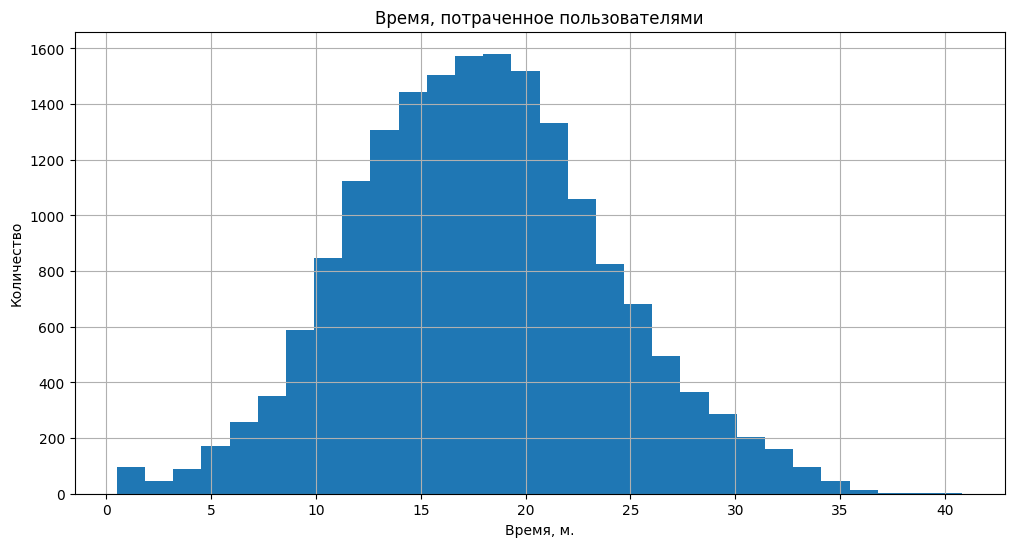

In [27]:
# Потроим гистограмму продолжительнотсти поездок
plt.figure(figsize=(12, 6))

plt.hist(rides_df['duration'], bins=30)
plt.xlabel('Время, м.')
# plt.xticks(range(10,45,2))
plt.ylabel('Количество')
plt.title('Время, потраченное пользователями')

plt.grid()
plt.show()

Мы видим, что время распределено тоже близко к нормально со средним примерно в 17 минут. Так же стоит отметить маленький выброс около нуля. Как мы видели ранее по гистограмме с дистанцией, у нас есть небольшой пласт пользователей, которые арендую самокаты на расстояние до 1км. На данной гистограмме это так же отражается

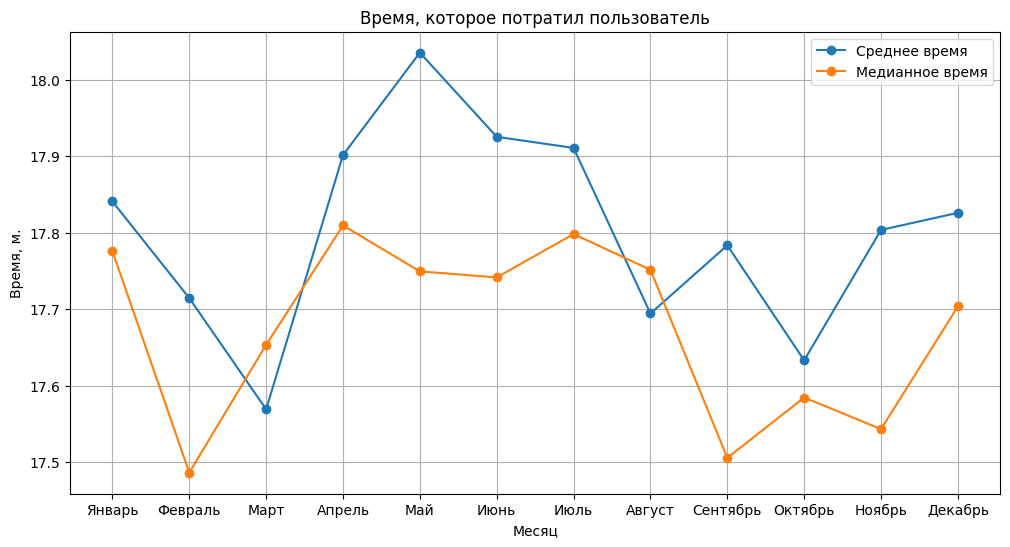

In [28]:
# Посмотрим на время поездок, которые совершают пользователи в зависимости от месяца
pivot_table_df = rides_df.pivot_table(index='month', values='duration',
                                      aggfunc=('mean', 'median', 'min', 'max', 'count')).sort_values('month')

pivot_table_df = pivot_table_df.rename(index={
    1: 'Январь',
    2: 'Февраль',
    3: 'Март',
    4: 'Апрель',
    5: 'Май',
    6: 'Июнь',
    7: 'Июль',
    8: 'Август',
    9: 'Сентябрь',
    10: 'Октябрь',
    11: 'Ноябрь',
    12: 'Декабрь'
}).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(pivot_table_df['month'], pivot_table_df[['mean', 'median']], marker='o')
plt.xlabel('Месяц')
plt.ylabel('Время, м.')
plt.title('Время, которое потратил пользователь')
plt.legend(('Среднее время', 'Медианное время'))

plt.grid(True)
plt.show()

Мы можем наблюдать то, что в теплые месяцы время поездки закономерно выше, чем в холодные, однако опять же декабрь и январь являются аномальными месяцами, которые не подчиняются данной логике. Так же стоит отметить, что хоть время и растет, однако глобально оно не сильно различается, ибо в феврале медианное время поездки составляет ~17.5 минут, а в апреле оно составляет ~17.8 минут. Можно утверждать, что медианное время составляет примерно `17.7 минут` 

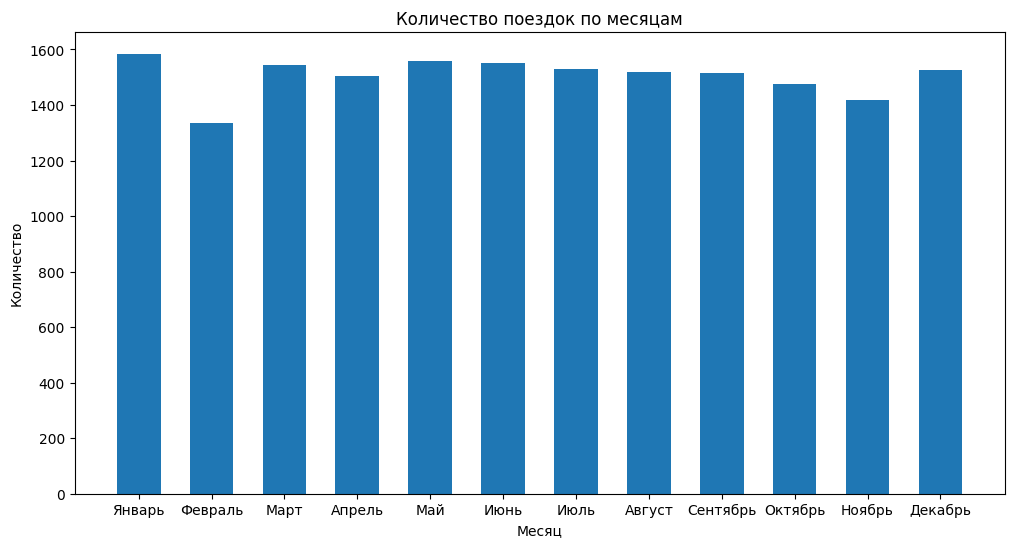

In [29]:
plt.figure(figsize=(12, 6))
plt.bar(pivot_table_df['month'], pivot_table_df['count'], width=0.6)
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.title('Количество поездок по месяцам')

plt.show()

Мы видим, что количество поездок примерно одинаковое вне зависимости от месяца. Слегка просаживается февраль, однако это может быть объяснено тем, что в этом месяце меньше дней, нежели в остальных

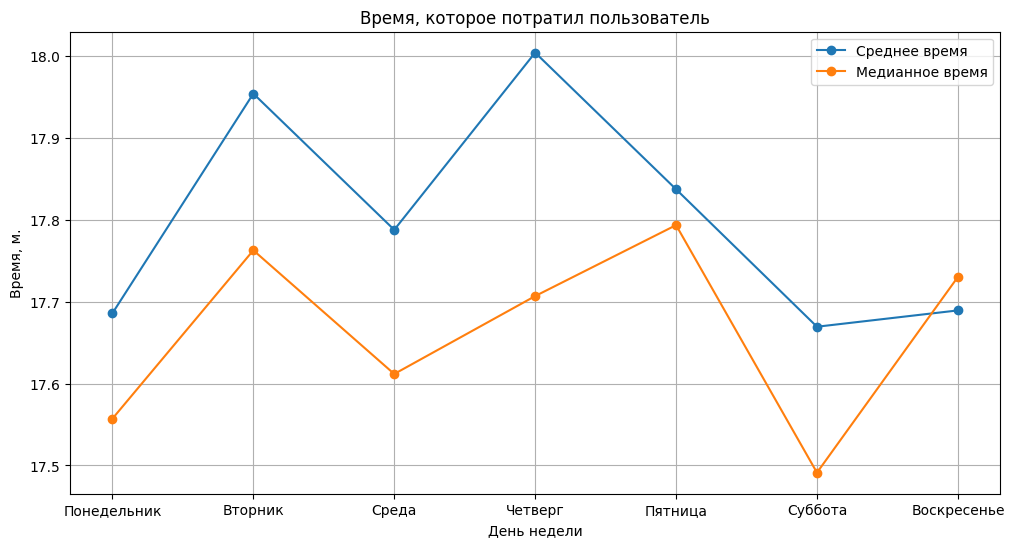

In [30]:
# Посмотрим на то, как день недели влияет на дистанцию поездки
pivot_table_df = rides_df.pivot_table(index='weekday', values='duration',
                                      aggfunc=('mean', 'median', 'min', 'max', 'count')).sort_values('weekday')

pivot_table_df = pivot_table_df.rename(index={
    0: 'Понедельник',
    1: 'Вторник',
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'}).reset_index()

# Рисуем график
plt.figure(figsize=(12, 6))
plt.plot(pivot_table_df['weekday'], pivot_table_df[['mean', 'median']], marker='o')
plt.xlabel('День недели')
plt.ylabel('Время, м.')
plt.title('Время, которое потратил пользователь')
plt.legend(('Среднее время', 'Медианное время'))

plt.grid(True)
plt.show()

Мы видим, что время, потраченное на поездку в будние дни в основном больше, чем в выходные. Можно предположить, что пользователи пользуются сервисом для того, чтобы добраться до работы, нежели для прогулок. Посмотрим, сколько поездок совершается в зависимости от дня недели

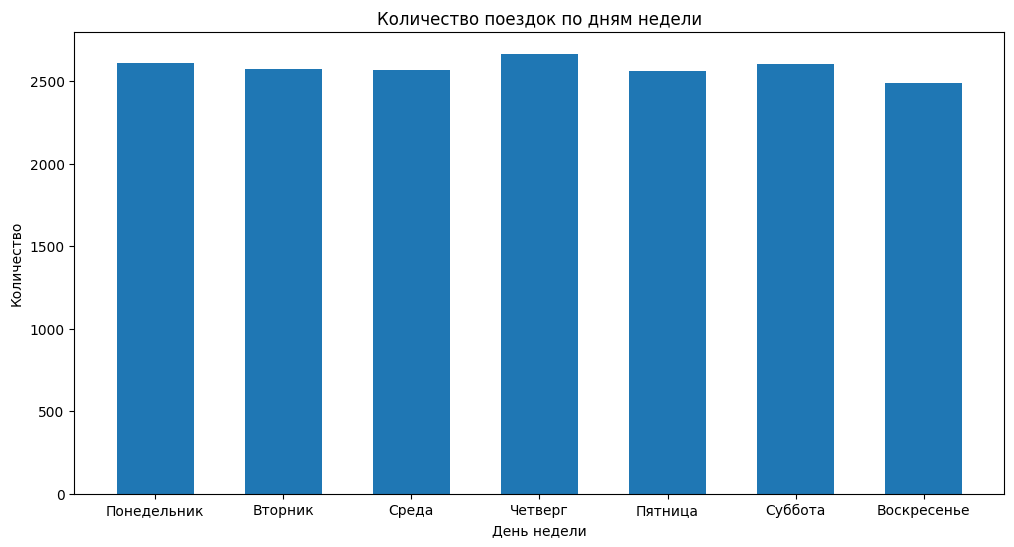

In [31]:
plt.figure(figsize=(12, 6))
plt.bar(pivot_table_df['weekday'], pivot_table_df['count'], width=0.6)
plt.xlabel('День недели')
plt.ylabel('Количество')
plt.title('Количество поездок по дням недели')

plt.show()

Количество поездок не сильно зависит от дня недели, так что гипотеза о том, что в будние дни время поездки выше, чем в выходные по той причине, что пользователи добираются на работу звучит все более правдоподобно.

##### Вывод:

- Во всех 8 городах примерно одинаковое количество пользователй. Меньше всего пользователей в `Москве`, в то время как больше всего пользователей в Пятигорске, однако разница между этими городами составляет всего `~50` пользователей 
- Всего у нас `835` пользователей с бесплатной подпиской и `699` пользователей с платной подпиской, что составляет `54% и 46%` от общего числа пользователей соответственно. На одного пользователя с платной подпиской приходится 1.19 пользователей с бесплатной подпиской
- Расстояние, которое преодолевает на самокате больше всего в теплые месяцы, однако стоит отметить "выброс" в декабре и январе. Так же интересно отметить, что наибольшее медианное расстояние пользователи проезжают по понедельникам, и вторникам, далее тенденция идет на спад. Меньше всего пользователи сервиса проезжают в пятницу.
- Минимальный, медианный, и максимальный возраст пользователей не сильно отличается в зависимости от города. Однако мы можем отметить Москву, как город, в котором максимальный возраст значительно отличается в сравнении с остальными городами. В Москве максимальный возраст составляет аж 43 года. 
- В теплые месяцы время поездки закономерно выше, чем в холодные, однако опять же декабрь и январь являются аномальными месяцами, которые не подчиняются данной логике. Так же стоит отметить, что хоть время и растет, однако глобально оно не сильно различается, ибо в феврале медианное время поездки составляет ~17.5 минут, а в апреле оно составляет ~17.8 минут. Можно утверждать, что медианное время составляет примерно `17.7 минут` 

#### Шаг 4. Объединение данных

##### Объединение всех данных

Объединим все 3 датафрейма в один

In [32]:
# Объединим 2 таблицы в одну по столбцу user_id
df = pd.merge(users_df, rides_df, on='user_id', how='left')
df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,weekday
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,4
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,0
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,1
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,2
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,5


In [33]:
# Объединим полученную таблицу с таблицей с информацией о цене
df = pd.merge(df, subscriptions_df, on='subscription_type', how='left')
df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,weekday,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,4,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,0,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,1,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,2,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,5,6,0,199


In [34]:
# Посмотрим на размер получившегося датафрейма
print('df size:', df.shape[0])

# Посмотри на наличие пропусков после объединения
df.isna().sum()

df size: 18068


user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
weekday              0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

##### Разделение пользователей

Создадим 2 отдельных датафрейма. В одном будут находится пользователи, у которых есть подписка, а в другой — пользователи без подписки

In [35]:
# Создадим 2 таблицы. В одну из них выделим пользователей с подпиской, в другую же без подписки
free_subscription_df = df[df['subscription_type'] == 'free']
ultra_subscription_df = df[df['subscription_type'] == 'ultra']

free_subscription_df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,weekday,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,5,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,0,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,3,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,6,8,50,0


In [36]:
ultra_subscription_df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,weekday,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,4,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,0,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,1,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,2,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,5,6,0,199


In [37]:
print('Общее количество строчек в исходном датафрейме:',df.shape[0])
print('Количество пользователей без подписки:',free_subscription_df.shape[0])
print('Количество пользователей с подпиской:',ultra_subscription_df.shape[0])

Общее количество строчек в исходном датафрейме: 18068
Количество пользователей без подписки: 11568
Количество пользователей с подпиской: 6500


##### Визуализация данных для пользователей

Посмотрим, как различаются данные в зависимости от того, есть ли у пользователя подписка

In [38]:
print(f"Медианное значение дистанции для пользователей без подписки:\
{free_subscription_df['distance'].median():.2f} м")
print(f"Медианное значение дистанции для пользователей c подпиской:\
{ultra_subscription_df['distance'].median():.2f} м")
print()
print(f"Медианное значение времени для пользователей без подписки:\
{free_subscription_df['duration'].median():.2f} минут")
print(f"Медианное значение времени для пользователей c подпиской:\
{ultra_subscription_df['duration'].median():.2f} минут")

Медианное значение дистанции для пользователей без подписки:3114.65 м
Медианное значение дистанции для пользователей c подпиской:3148.64 м

Медианное значение времени для пользователей без подписки:17.33 минут
Медианное значение времени для пользователей c подпиской:18.18 минут


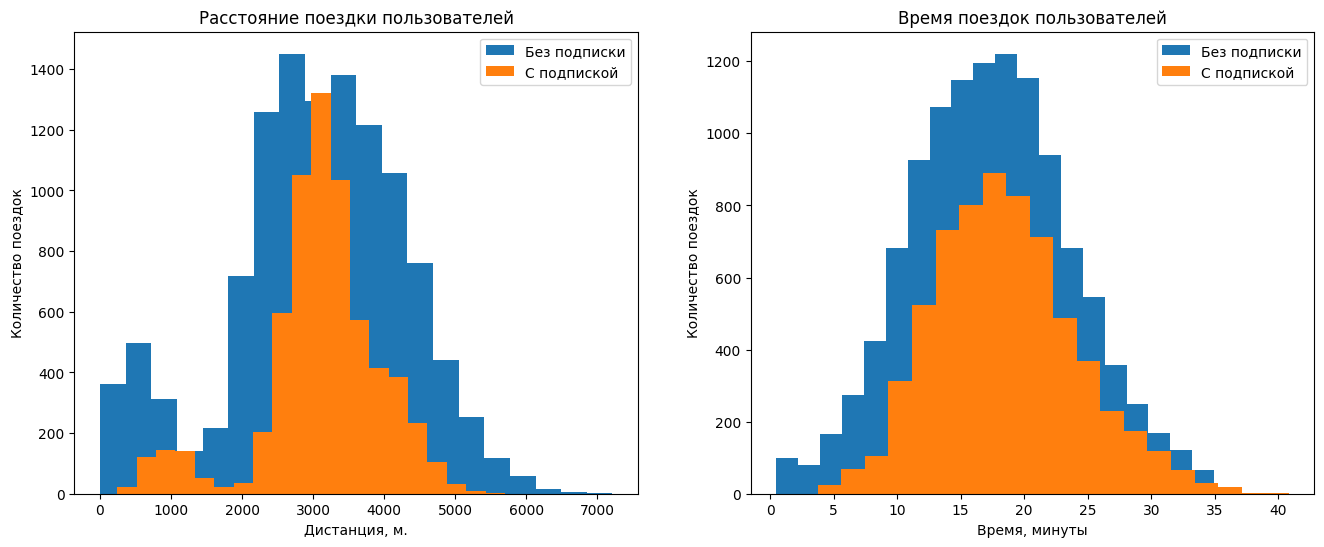

In [39]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.hist(free_subscription_df['distance'], bins=20, label='Без подписки')
plt.hist(ultra_subscription_df['distance'], bins=20, label='С подпиской')
plt.legend()
plt.xlabel('Дистанция, м.')
plt.ylabel('Количество поездок')
plt.title('Расстояние поездки пользователей')

plt.subplot(1, 2, 2)
plt.hist(free_subscription_df['duration'], bins=20, label='Без подписки')
plt.hist(ultra_subscription_df['duration'], bins=20, label='С подпиской')
plt.legend()
plt.xlabel('Время, минуты')
plt.ylabel('Количество поездок')
plt.title('Время поездок пользователей')

plt.show()

##### Вывод:

- Медианное расстояние для пользователей без подписки составляет `3114 метров`
- Медианное время для пользователей без подписки составляет `17.5 минут`
- Медианное расстояние для пользователей с подпиской составляет `3150 метров`
- Медианное время для пользователей с подпиской составляет `18 минут`


Мы можем наблюдать, что время поездки для пользователей с подпиской и без нее практически не различается. Единственное отличие, которое можно заметить — это высота столбцов гистограммы, однако это объясняется тем, что количество пользователей с подпиской меньше, нежели без нее. В случае с расстоянием, все немного сложнее: гистограммы не похожи друг на друга. Пользователи без подписки чаще проезжают расстояние меньше 1км. Пользователи без подписки так же равномерно проезжают расстояния от ~2200м до ~3800, в то время как пользователи с подпиской проезжают в основном расстояние равное ~3000м. У пользователей с подпиской и без, медианные значения примерно одинаковые и составляют около `3150 метров`, однако дисперсия у пользователей с подпиской меньше. Так же стоит отметить, что пользователи без подписки чаще проезжают большее расстояние: 5000м для пользователей с подпиской, против почти 7000м для пользователей без подписки

#### Шаг 5. Подсчёт выручки

Создайм датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из предыдущего шага. Найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
<br>
<br>
Добавим в эту таблицу столбец с помесячной выручкой для каждого пользователя

In [40]:
# Объединяем данные
aggregated_df = pd.concat([free_subscription_df, ultra_subscription_df], ignore_index=True)
# Удаляем более не нужный нам столбец
aggregated_df = aggregated_df.drop(columns='weekday')
# Округляем продолжительность поездки
aggregated_df['duration'] = np.ceil(aggregated_df['duration'])

aggregated_df.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,700,Айдар,22,Омск,free,2515.690719,15.0,2021-01-02,1,8,50,0
1,700,Айдар,22,Омск,free,846.932642,17.0,2021-02-01,2,8,50,0
2,700,Айдар,22,Омск,free,4004.434142,21.0,2021-02-04,2,8,50,0
3,700,Айдар,22,Омск,free,1205.911290,10.0,2021-02-10,2,8,50,0
4,700,Айдар,22,Омск,free,3047.379435,18.0,2021-02-14,2,8,50,0
5,700,Айдар,22,Омск,free,4342.002254,23.0,2021-02-23,2,8,50,0
6,700,Айдар,22,Омск,free,3798.334905,19.0,2021-03-03,3,8,50,0
7,700,Айдар,22,Омск,free,2984.551206,16.0,2021-04-09,4,8,50,0
8,700,Айдар,22,Омск,free,3360.107141,17.0,2021-06-12,6,8,50,0
9,700,Айдар,22,Омск,free,2567.543847,12.0,2021-06-23,6,8,50,0


In [41]:
aggregated_df['subscription_type'].head()

0    free
1    free
2    free
3    free
4    free
Name: subscription_type, dtype: object

In [42]:
aggregated_pivot_table = (aggregated_df.pivot_table(index=('user_id', 'month'),
                                                    values=('distance', 'duration', 'date',
                                                            'subscription_fee', 'minute_price',
                                                            'start_ride_price'),
                                                    aggfunc={
                                                        'distance': 'sum',
                                                        'duration': 'sum',
                                                        'date': 'count',
                                                        'minute_price': 'first',
                                                        'start_ride_price': 'first',
                                                        'subscription_fee': 'first'
                                                    }, fill_value=0)
                          .rename(columns={'date': 'ride_count',
                                           'distance': 'distance_sum',
                                           'duration': 'duration_sum', }))
aggregated_pivot_table.head()

ride_count  distance_sum  duration_sum  minute_price  \
user_id month                                                         
1       1               2   7027.511294          42.0             6   
        4               1    754.159807           7.0             6   
        8               2   6723.470560          46.0             6   
        10              2   5809.911100          32.0             6   
        11              3   7003.499363          56.0             6   

               start_ride_price  subscription_fee  
user_id month                                      
1       1                     0               199  
        4                     0               199  
        8                     0               199  
        10                    0               199  
        11                    0               199

In [43]:
# Посмотрим, есть ли у нас пропуски в новой таблице
aggregated_pivot_table.isna().sum()

ride_count          0
distance_sum        0
duration_sum        0
minute_price        0
start_ride_price    0
subscription_fee    0
dtype: int64

In [44]:
def calculate_income(row):
    result = row['start_ride_price'] * row['ride_count'] +\
    row['minute_price'] * row['duration_sum'] + row['subscription_fee']
    
    return result

aggregated_pivot_table['month_income'] = aggregated_pivot_table.apply(calculate_income, axis=1)

aggregated_pivot_table.head(10)

ride_count  distance_sum  duration_sum  minute_price  \
user_id month                                                         
1       1               2   7027.511294          42.0             6   
        4               1    754.159807           7.0             6   
        8               2   6723.470560          46.0             6   
        10              2   5809.911100          32.0             6   
        11              3   7003.499363          56.0             6   
        12              2   6751.629942          28.0             6   
2       3               3  10187.723006          63.0             6   
        4               2   6164.381824          40.0             6   
        6               1   3255.338202          14.0             6   
        7               2   6780.722964          48.0             6   

               start_ride_price  subscription_fee  month_income  
user_id month                                                    
1       1                     0               199         451.0  
        4                     0               199         241.0  
        8                     0               199         475.0  
        10                    0               199         391.0  
        11                    0               199         535.0  
        12                    0               199         367.0  
2       3                     0               199         577.0  
        4                     0               199         439.0  
        6                     0               199         283.0  
        7                     0               199         487.0

##### Вывод:

Для подсчета выручки, мы создали сводную таблицу, в которой были как пользователи с подпиской, так и без нее, после чего сгруппировали данные по `user_id` и месяцу, тем самым посчитав, какую выручку принес каждый пользователь за каждый месяц

#### Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов

In [45]:
# Проверим, сколько всего у нас пользователей с подпиской и без нее
print('Количество пользователей без подписки:',free_subscription_df.shape[0])
print('Количество пользователей с подпиской:',ultra_subscription_df.shape[0])

Количество пользователей без подписки: 11568
Количество пользователей с подпиской: 6500


##### Гипотеза №1

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.
<br>
<br>
**h0** — Среднее время поездки пользователей с подпиской равно среднему времени пользователей без подписки
<br>
**h1** — Среднее время поездки пользователей с подпиской больше среднего времени пользователей без подписки

In [46]:
free_sample = free_subscription_df['duration']#.sample(frac=0.5)
ultra_sample = ultra_subscription_df['duration']#.sample(frac=0.5)

result = stats.ttest_ind(ultra_sample, free_sample, alternative='greater')
# result = stats.ttest_ind(free_sample, ultra_sample, alternative='greater')
alpha = 0.05

print('p-value:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу в пользу альтернативной


Так как мы отвергли нулевую гипотезу в пользу альтернативной, то мы можем утверждать, что пользователи с подпиской проводят больше времени за одну поездку

##### Гипотеза №2

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
<br>
<br>
**h0** — Среднее расстояние, которое проезжает пользователей с подпиской составляет 3130 метров
<br>
**h1** — Среднее расстояние, которое проезжает пользователей с подпиской составляет больше 3130 метров

In [47]:
interested_value = 3130
sample = ultra_subscription_df['distance']#.sample(frac=0.5)

result = stats.ttest_1samp(sample, interested_value, alternative='greater')
alpha = 0.05

print('p-value:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Нам не удалось отвергнуть нулевую гипотезу. В качестве альтернативной гипотезы мы выбрали гипотезу, при которой расстояние будет больше 3130 метров. Так как мы не смогли отвергнуть нулевую гипотезу в пользу альтернативной, то это означает, что среднее расстояние равно, или же меньше (не превышает) 3130 метров.

In [48]:
sample.mean()

np.float64(3115.4453880370247)

In [49]:
# Проверяю, как выглядит столбец, из которого я беру выборку
aggregated_pivot_table.loc[aggregated_pivot_table['subscription_fee'] == 0, 'month_income'].head(10)

user_id  month
700      1        170.0
         2        962.0
         3        202.0
         4        178.0
         6        332.0
         7        268.0
         8        186.0
         10       452.0
         11       406.0
701      1        194.0
Name: month_income, dtype: float64

##### Гипотеза №3

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
<br>
<br>
**h0** — Помесячная выручка от пользователей с подпиской равна помесячной выручке от пользователей без подписки.
<br>
**h1** — Помесячная выручка от пользователей с подпиской больше помесячной выручке от пользователей без подписки.

In [51]:
free_sample = aggregated_pivot_table.loc[aggregated_pivot_table['subscription_fee'] == 0, 'month_income']#.sample(frac=0.5)
ultra_sample = aggregated_pivot_table.loc[aggregated_pivot_table['subscription_fee'] == 199, 'month_income']#.sample(frac=0.5)

result = stats.ttest_ind(ultra_sample, free_sample, alternative='greater')
alpha = 0.05

print('p-value:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу в пользу альтернативной


In [52]:
# Проверка
print(free_sample.mean())
print(ultra_sample.mean())

328.6413651073845
362.7921906022502


Так как мы отвергаем нулевую гипотезу в пользу альтернативной, то можем сказать, что в среднем, пользователи с подпиской приносят большую помесячную выручку, чем пользователи без нее

<b>Вопрос: Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?</b>

<br>
<br>

Ответ: В данном случае нам бы подошел <code>ttest_rel(sample_before, sample_after, alternative='greater')</code>, потому что данный тест проверяет гипотезу о равенстве среднего до и после изменений, при условии, что каждое значение значение находится "на своем месте". Так как нам интересно узнать, снизилось ли количество обращений, то мы указываем параметр <code>alternative='greater'</code>, потому что при указании <code>alternative='less'</code>, будет проверяться левостороняя альтернативная гипотеза о том, что истинное среднее генеральной совокупности до изменения меньше, чем после. При указании же <code>alternative='greater'</code> проверяется правосторонняя. То, насколько сильно снизилось количество обращений, указывается в параметр alpha, который является важностью статистической значимости.

##### Вывод:

Всего нам надо было проверить 3 гипотезы:
1. Тратят ли пользователи с подпиской больше времени на поездки?
2. Проезжают ли пользователи меньше, чем 3130 метров за одну поездку?
3. Приносят ли пользователи с подпиской в месяц больше выручки, чем пользователи без нее?

Результаты проверок гипотез:
1. Первую гипотезу мы подтвердили, так что можно сказать, что пользователи с подпиской тратят больше времени на поездки, нежели пользователи без нее 
2. Вторую гипотезу мы подтвердили, пользователи с подпиской проезжают расстояние, не превышающее 3130 метров
3. Третью гипотезу мы так же подтвердили. Пользователи с подпиской в среднем приносят больше прибиль в месяц, чем пользователи без подписки

#### Шаг 7. Распределения

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с
раздачей промокодов на один бесплатный месяц подписки, в рамках которой как
минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте
ответ на вопрос о количестве промокодов.

In [53]:
from scipy.stats import binom
import numpy as np

p = 0.1
n = 800

# Начать можно с ~900.
for n in range(800, 1800):
    if binom.cdf(99, n, p) <= 0.05:
      print("Минимальное количество промокодов: ", n)
      break


Минимальное количество промокодов:  1161


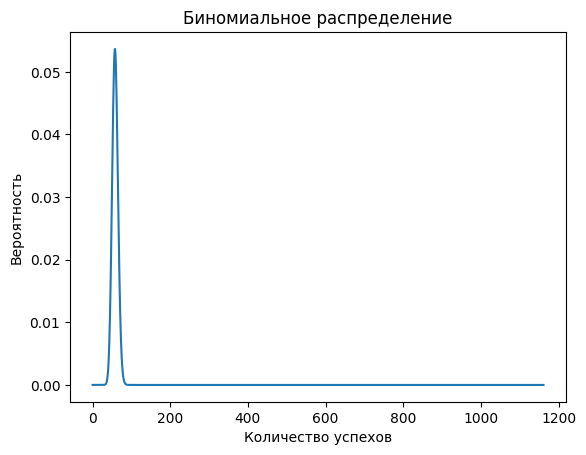

In [54]:
# Параметры биномиального распределения
import warnings
warnings.filterwarnings("ignore")

n = 1161  # Количество промокодов
p = 0.05  # Вероятность успеха

# Значения для оси x (количество успехов)
x = range(n + 1)

# Значения для оси y (вероятность)
y = binom.pmf(x, n, p)

# Построение графика
plt.plot(x, y)
plt.xlabel("Количество успехов")
plt.ylabel("Вероятность")
plt.title("Биномиальное распределение")
plt.show()

In [55]:
from scipy.stats import binom
import numpy as np

p = 0.1
n = 100

for n in range(100, 1800):
    if binom.cdf(99, n, p) <= 0.05:
      print("Минимальное количество промокодов: ", n)
      break


Минимальное количество промокодов:  1161


**Задача:**
Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [56]:
p = 0.4
n = 10**6
x = 399500

mu = n * p
sigma = math.sqrt(n * p * (1 - p))
distr = stats.norm(mu, sigma)

print(f'Вероятность, что письмо откроют меньше {x} пользователей составляет {distr.cdf(x) * 100:.1f}%')

Вероятность, что письмо откроют меньше 399500 пользователей составляет 15.4%


##### Вывод:

Если отдел маркетинга отправит письмо миллиону пользователей, то вероятность того, что его откроет меньше `399500 человек` составляет `15.4%`

#### Общий вывод:

Пользователи 

Данные о пользователях:
- Во всех 8 городах примерно одинаковое количество пользователй. Меньше всего пользователей в `Москве`, в то время как больше всего пользователей в Пятигорске
- Всего у нас `835` пользователей с бесплатной подпиской и `699` пользователей с платной подпиской, что составляет `54% и 46%` от общего числа пользователей соответственно. На одного пользователя с платной подпиской приходится 1.19 пользователей с бесплатной подпиской
- Расстояние, которое преодолевает на самокате больше всего в теплые месяцы, 
- Минимальный, медианный, и максимальный возраст пользователей не сильно отличается в зависимости от города. Медианный возраст составляет `25` лет
- В теплые месяцы время поездки закономерно выше, чем в холодные, медианное время составляет примерно `17.7 минут` 

<br>
<br>

Данные о поездках:
- Медианное расстояние для пользователей без подписки составляет `3114 метров`
- Медианное время для пользователей без подписки составляет `17.5 минут`
- Медианное расстояние для пользователей с подпиской составляет `3150 метров`
- Медианное время для пользователей с подпиской составляет `18 минут`


Мы можем наблюдать, что время поездки для пользователей с подпиской и без нее практически не различается. Пользователи без подписки чаще проезжают расстояние меньше 1км. Пользователи без подписки так же равномерно проезжают расстояния от ~2200м до ~3800, в то время как пользователи с подпиской проезжают в основном расстояние равное ~3000м. У пользователей с подпиской и без, медианные значения примерно одинаковые и составляют около `3150 метров`, однако дисперсия у пользователей с подпиской меньше. Так же стоит отметить, что пользователи без подписки чаще проезжают большее расстояние: 5000м для пользователей с подпиской, против почти 7000м для пользователей без подписки

<br>
<br>

Результаты проверок гипотез:
1. Первую гипотезу мы подтвердили, так что можно сказать, что пользователи с подпиской тратят больше времени на поездки, нежели пользователи без нее 
2. Вторую гипотезу мы подтвердили, пользователи с подпиской проезжают расстояние, не превышающее 3130 метров
3. Третью гипотезу мы так же подтвердили. Пользователи с подпиской в среднем приносят больше прибиль в месяц, чем пользователи без подписки

Так же стоит отметить, что при вероятности открытия письма, равной `0.4`, то если отдел маркетинга отправит письмо миллиону пользователей, то вероятность того, что его откроет меньше `399500 человек` составляет `15.4%`

<br>
<br>

Проделанная работа:
- Столбце `date` приведен к необходимому формату
- Все датафреймы объеденины в один
- Созданая сводная таблица
- Созданы отдельные датафреймы для пользователей с подпиской и без
- Добавлен столбец с помесячной выручкой для каждого пользователя
- Был удален 31 явный дубликат в таблице с пользователями